In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import scipy.integrate as integrate

import gym
from gym import spaces

import random
import itertools as it
from joblib import Parallel, delayed
from toolz import memoize
from contracts import contract
from collections import namedtuple, defaultdict, deque, Counter

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

from agents import Agent
from newmouselab import NewMouselabEnv
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *
from distributions import cmax, smax, sample, expectation, Normal, PointMass, SampleDist, TruncatedNormal, Categorical

In [2]:
import ipyparallel as ipp 
rc = ipp.Client(profile='default', cluster_id='')
ipp.register_joblib_backend()

ModuleNotFoundError: No module named 'ipyparallel'

# Mouselab Environment

In [7]:
gambles = 4
attributes = 4
reward = Normal(2,1)
cost=0.03
env = NewMouselabEnv(gambles, attributes, reward, cost)

In [8]:
env.action_features(4)

array([-0.03 ,  0.1  ,  0.199,  0.649,  2.   ])

In [9]:
attributes = 4
env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=0.15)

In [10]:
env._state[0].ground_truth

array([  1.405e-02,   5.263e-09,   1.576e-04,   9.858e-01])

In [11]:
attributes = 4
env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=1.5)

In [12]:
env._state[0].ground_truth

array([ 0.664,  0.011,  0.136,  0.189])

In [13]:
env.action_features(4)

array([-0.03 ,  0.1  ,  0.199,  0.608,  2.   ])

In [14]:
state = env.reset()

In [15]:
list(env.actions(state))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## Time features

In [16]:
import datetime

In [17]:
env.dist

array([ 0.25,  0.25,  0.25,  0.25])

### VPI_all

In [24]:
a = datetime.datetime.now()
b = []
for i in range(100):
    b.append(env.vpi())
t = datetime.datetime.now() - a
print(t)
print(np.mean(b))

0:00:00.000176
0.607749360206


### VPI_action

In [25]:
a = datetime.datetime.now()
b = []
for i in range(100):
    b.append(env.vpi_action(2))
t = datetime.datetime.now() - a
print(t)
print(np.mean(b))

0:00:00.000160
0.199471140201


### Myopic_VOI

In [26]:
a = datetime.datetime.now()
b = []
for i in range(100):
    b.append(env.myopic_voi(0))
t = datetime.datetime.now() - a
print(t)
print(np.mean(b))

0:00:00.085242
0.0


# Training

In [27]:
def hd_dist(attributes):
    dist = [1,]*attributes
    dist[0] = np.random.randint(85,97)
    for i in range(1,attributes-1):
        dist[i] += np.random.randint(0,100-np.sum(dist))
    dist[-1] += 100-np.sum(dist)
    dist = np.around(np.array(dist)/100,decimals=2)
    np.random.shuffle(dist)
    return dist

In [28]:
for _ in range(1000):
    if np.max(hd_dist(4)) < 0.85:
        print('goshdarn')
        break

In [29]:
def ld_dist(attributes):
    constrain = True
    while constrain:
        dist = [np.random.randint(10,50) for _ in range(attributes)]
        dist = np.around(np.array(dist)/sum(dist),decimals=2)
        constrain = np.min(dist) <= 0.10 or np.max(dist) >= 0.40
    np.random.shuffle(dist)
    return dist

In [30]:
for _ in range(1000):
    dist = ld_dist(4)
    if np.min(dist) <= 0.10 or np.max(dist) >= 0.40:
        print('goshdarn')
        break

## High Stakes 1 cents

In [36]:
gambles = 7
attributes = 4
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = high_stakes
cost=.03

#set to 20 for sanity check
n_train = 20
n_test = 20

train_envs_hd = [NewMouselabEnv(gambles, attributes, reward, cost, alpha=0.15) for _ in range(n_train)]
train_envs_ld = [NewMouselabEnv(gambles, attributes, reward, cost, alpha=1.5) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd = [NewMouselabEnv(gambles, attributes, reward, cost, alpha=0.15) for _ in range(n_train)]
test_envs_ld = [NewMouselabEnv(gambles, attributes, reward, cost, alpha=1.5) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [37]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=20, n_calls=20,
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 16.916   0.384   0.324   0.293   1.   ] -> 7.132 in 131 sec
[ 13.286   0.327   0.222   0.451   1.   ] -> 7.229 in 175 sec
[ 28.946   0.225   0.465   0.31    1.   ] -> 6.688 in 117 sec
[ 17.473   0.854   0.066   0.08    1.   ] -> 5.312 in 47 sec


/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[ 1.586  0.336  0.314  0.351  1.   ] -> 7.562 in 225 sec
[ 29.38    0.392   0.226   0.382   1.   ] -> 6.626 in 117 sec
[ 4.43   0.37   0.083  0.547  1.   ] -> 7.55 in 277 sec
[ 16.134   0.285   0.182   0.533   1.   ] -> 7.324 in 171 sec


/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[ 14.228   0.472   0.016   0.513   1.   ] -> 7.054 in 262 sec
[ 18.751   0.275   0.421   0.304   1.   ] -> 7.069 in 122 sec
[ 1.   0.   0.5  0.5  1. ] -> 7.381 in 353 sec
[ 1.     0.548  0.     0.452  1.   ] -> 7.416 in 311 sec
[ 1.     0.     0.597  0.403  1.   ] -> 7.378 in 350 sec


/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[ 1.  0.  0.  1.  1.] -> 7.126 in 302 sec


/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[ 1.     0.333  0.333  0.333  1.   ] -> 7.598 in 228 sec
[ 1.     0.333  0.333  0.333  1.   ] -> 7.581 in 230 sec


/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/sayangul/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[ 1.     0.333  0.333  0.333  1.   ] -> 7.559 in 227 sec
[ 1.     0.241  0.38   0.38   1.   ] -> 7.591 in 229 sec
[ 1.051  0.314  0.354  0.332  1.   ] -> 7.559 in 234 sec
[ 1.   0.5  0.   0.5  1. ] -> 7.418 in 307 sec
BO: [ 1.     0.333  0.333  0.333  1.   ] -> 7.598 in 4421 sec
1:13:40.535829


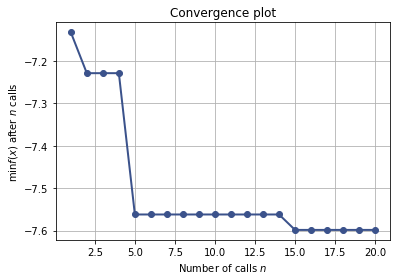

In [38]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [39]:
bo_pol.theta

array([ 1.   ,  0.333,  0.333,  0.333,  1.   ])

In [40]:
# np.save('high_stakes_3cents',bo_pol.theta)

In [41]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [42]:
np.mean(bo_utils)

7.4526281335915865

In [43]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [44]:
np.mean(mg_utils)

6.5474745857125978

In [38]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=nan, pvalue=nan)

In [39]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=nan, pvalue=nan)

In [45]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [46]:
np.mean(no_utils)

5.0

In [47]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [48]:
np.mean(fo_utils)

6.8361839361895447

In [44]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':0.03,'policy':p})

In [39]:
df[df['policy'] == 'metagreedy'].util.mean()

5.0

## Individual Policies 1 cents

In [59]:
gambles = 7
attributes = 4
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
low_stakes = TruncatedNormal((0.25+0.01)/2, 0.3*(0.25-0.01),0.01,0.25)
cost=.01

#set to 20 for sanity check
n_train = 500
# n_test = 500

train_hs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), high_stakes, cost) for _ in range(n_train)]
train_hs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), high_stakes, cost) for _ in range(n_train)]
train_ls_hd = [OldMouselabEnv(gambles, hd_dist(attributes), low_stakes, cost) for _ in range(n_train)]
train_ls_ld = [OldMouselabEnv(gambles, ld_dist(attributes), low_stakes, cost) for _ in range(n_train)]

test_hs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), high_stakes, cost) for _ in range(n_train)]
test_hs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), high_stakes, cost) for _ in range(n_train)]
test_ls_hd = [OldMouselabEnv(gambles, hd_dist(attributes), low_stakes, cost) for _ in range(n_train)]
test_ls_ld = [OldMouselabEnv(gambles, ld_dist(attributes), low_stakes, cost) for _ in range(n_train)]

term_action = train_hs_hd[0].term_action

In [ ]:
bo_pol, result = bo_policy(train_hs_hd, max_cost=30, n_jobs=100, n_calls=20,
                           verbose=1, normalize_voi=True, return_result=True)
np.save('data/hs_hd_1cents-2',bo_pol.theta)

[ 18.192   0.331   0.337   0.332   1.   ] -> 7.787 in 146 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 7.784 in 136 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 7.789 in 157 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 7.788 in 155 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 7.789 in 156 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 7.786 in 150 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 7.78 in 145 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 7.789 in 163 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 7.788 in 160 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 7.787 in 161 sec
[ 1.     0.333  0.333  0.333  1.   ] -> 7.789 in 169 sec
[ 1.3    0.82   0.165  0.014  1.   ] -> 7.789 in 165 sec
[ 1.098  0.     0.067  0.933  1.   ] -> 7.654 in 318 sec
[ 30.   1.   0.   0.   1.] -> 7.667 in 121 sec
[ 2.024  0.448  0.318  0.234  1.   ] -> 7.79 in 165 sec


In [ ]:
hs_hd_utils = get_util(bo_pol, test_hs_hd, parallel=Parallel(n_jobs=100),return_mean=False)

In [ ]:
d_list = []
for result in hs_hd_utils:
    d_list.append({'util':result,'stakes':'high','cost':cost,'disp':'high'})
df = pd.DataFrame(d_list)
df.to_hdf('data/hs_hd_1cents_results-2','results')

In [18]:
df2 = pd.read_hdf('data/hs_hd_1cents_results-2','results')
df2.util.mean()

7.816494466110364

In [ ]:
bo_pol, result = bo_policy(train_hs_ld, max_cost=30, n_jobs=100, n_calls=20,
                           verbose=1, normalize_voi=True, return_result=True)
np.save('data/hs_ld_1cents-2',bo_pol.theta)

In [ ]:
hs_ld_utils = get_util(bo_pol, test_hs_ld, parallel=Parallel(n_jobs=100),return_mean=False)

In [ ]:
d_list = []
for result in hs_ld_utils:
    d_list.append({'util':result,'stakes':'high','cost':cost,'disp':'low'})
df = pd.DataFrame(d_list)
df.to_hdf('data/hs_ld_1cents_results-2','results')

In [19]:
df2 = pd.read_hdf('data/hs_ld_1cents_results-2','results')
df2.util.mean()

6.525158221767088

In [ ]:
bo_pol, result = bo_policy(train_ls_hd, max_cost=30, n_jobs=100, n_calls=20,
                           verbose=1, normalize_voi=True, return_result=True)
np.save('data/ls_hd_1cents-2',bo_pol.theta)

In [ ]:
ls_hd_utils = get_util(bo_pol, test_ls_hd, parallel=Parallel(n_jobs=100),return_mean=False)

In [ ]:
d_list = []
for result in ls_hd_utils:
    d_list.append({'util':result,'stakes':'low','cost':cost,'disp':'high'})
df = pd.DataFrame(d_list)
df.to_hdf('data/ls_hd_1cents_results-2','results')

In [20]:
df2 = pd.read_hdf('data/ls_hd_1cents_results-2','results')
df2.util.mean()

0.1552926010921473

In [ ]:
bo_pol, result = bo_policy(train_ls_ld, max_cost=30, n_jobs=100, n_calls=20,
                           verbose=1, normalize_voi=True, return_result=True)
np.save('data/ls_ld_1cents-2',bo_pol.theta)

In [ ]:
ls_ld_utils = get_util(bo_pol, test_ls_ld, parallel=Parallel(n_jobs=100),return_mean=False)

In [ ]:
d_list = []
for result in ls_ld_utils:
    d_list.append({'util':result,'stakes':'low','cost':cost,'disp':'low'})
df = pd.DataFrame(d_list)
df.to_hdf('data/ls_ld_1cents_results-2','results')

In [21]:
df2 = pd.read_hdf('data/ls_ld_1cents_results-2','results')
df2.util.mean()

0.13000000000000103

## High Stakes 1 cents

In [60]:
theta = list(np.load('data/high_stakes_1cents-prev.npy'))
theta

[2.4259942112319113, 0.67950073753337825, 0.0, 0.32049926246662169, 1.0]

In [22]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
low_stakes = TruncatedNormal((0.25+0.01)/2, 0.3*(0.25-0.01),0.01,0.25)
reward = high_stakes
cost=.01

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [30]:
for env in train_envs_ld:
    dist = env.dist
    if np.min(dist) <= 0.10 or np.max(dist) >= 0.40:
        print('goshdarn')
        break

In [ ]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=100, n_calls=20, x0=theta[:-1],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

In [ ]:
# bo_pol_theta = np.load('low_stakes_0.5cents-2.npy')
# bo_pol = LiederPolicy(list(bo_pol_theta))

In [ ]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [ ]:
bo_pol.theta

In [ ]:
np.save('data/high_stakes_trunc_1cents-6',bo_pol.theta)

In [ ]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(bo_utils)

In [ ]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(mg_utils)

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

In [ ]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(no_utils)

In [ ]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(fo_utils)

In [ ]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [ ]:
df = pd.DataFrame(d_list)
df

In [ ]:
df[df['policy'] == 'metagreedy'].util.mean()

In [ ]:
df.to_hdf('data/high_stakes_trunc_1cents_results-6','results')

In [ ]:
df2 = pd.read_hdf('data/high_stakes_trunc_1cents_results-6','results')

In [ ]:
df2[df2['policy']=='metagreedy'].util.mean()

In [ ]:
df2.groupby('policy').util.mean()

## Validation

In [23]:
filenames = ['high_stakes_1cents.npy', 'high_stakes_trunc_1cents.npy', 'high_stakes_trunc_1cents-2.npy', 
             'high_stakes_trunc_1cents-3.npy','low_stakes_1cents-previous.npy','high_stakes_1cents-prev.npy',
             'high_stakes_trunc_1cents-4.npy','high_stakes_trunc_1cents-5.npy']
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
reward = high_stakes
n_train = 250
cost=.01
test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train*4)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train*4)]

In [ ]:
val_util = []
d_list = []
for polfil in filenames:
    bo_pol_theta = np.load('data/'+polfil)
    print(bo_pol_theta)
    bo_pol = LiederPolicy(list(bo_pol_theta))
    
    polutil_hd = get_util(bo_pol, test_envs_hd, parallel=Parallel(n_jobs=20),return_mean=False)
    print(np.mean(polutil_hd))
    for result in polutil_hd:
        d_list.append({'util':result,'disp':'hd','policy':polfil})
        
    polutil_ld = get_util(bo_pol, test_envs_ld, parallel=Parallel(n_jobs=20),return_mean=False)
    print(np.mean(polutil_ld))
    for result in polutil_ld:
        d_list.append({'util':result,'disp':'ld','policy':polfil})
        
    val_util.append(np.mean(polutil_hd))
    val_util.append(np.mean(polutil_ld))
df_comb = pd.DataFrame(d_list)
df_comb.to_hdf('data/high_stakes_val_1cents_comb_results-2','results')

[ 1.     0.405  0.405  0.19   1.   ]


In [2]:
df_comb = pd.read_hdf('data/high_stakes_val_1cents_comb_results-2','results')

In [3]:
df_comb.groupby('policy').util.mean()

policy
high_stakes_1cents-prev.npy       7.144511
high_stakes_1cents.npy            7.147967
high_stakes_trunc_1cents-2.npy    7.150941
high_stakes_trunc_1cents-3.npy    7.146371
high_stakes_trunc_1cents-4.npy    7.151704
high_stakes_trunc_1cents-5.npy    7.142104
high_stakes_trunc_1cents.npy      7.144583
low_stakes_1cents-previous.npy    7.147655
Name: util, dtype: float64

In [20]:
df = df_comb

In [24]:
std_errs = [df[df['policy'] == polfil].util.std()*1.96/np.sqrt(2000) for polfil in filenames]

In [25]:
std_errs

[0.050122603757208006,
 0.049106754648099042,
 0.049012554706031226,
 0.049144514404010485,
 0.04912032261528021,
 0.049904411383318838,
 0.049521653169151546,
 0.048995628300695711]

In [26]:
means = [df[df['policy'] == polfil].util.mean() for polfil in filenames]

In [27]:
means

[7.147966594908242,
 7.14458275114287,
 7.150940572407325,
 7.146371440329115,
 7.147655161304414,
 7.144510512735714,
 7.151704452947731,
 7.142104427826357]

## Low Stakes 1 cents

In [89]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
low_stakes = TruncatedNormal((0.25+0.01)/2, 0.3*(0.25-0.01),0.01,0.25)
reward = low_stakes
cost=.01

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [90]:
for env in train_envs_ld:
    dist = env.dist
    if np.min(dist) <= 0.10 or np.max(dist) >= 0.40:
        print('goshdarn')
        break

In [91]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=100, n_calls=20,
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 18.192   0.331   0.337   0.332   1.   ] -> 0.13 in 39 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 0.13 in 39 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 0.13 in 39 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 0.13 in 39 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 0.13 in 39 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 0.13 in 39 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 0.13 in 39 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 0.142 in 81 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 0.13 in 39 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 0.13 in 39 sec
[ 1.  0.  0.  1.  1.] -> -0.01 in 433 sec
[ 30.      0.333   0.333   0.333   1.   ] -> 0.13 in 39 sec
[ 1.     0.375  0.251  0.375  1.   ] -> 0.123 in 205 sec
[ 30.    0.5   0.5   0.    1. ] -> 0.13 in 39 sec
[ 19.032   0.129   0.806   0.065   1.   ] -> 0.13 in 39 sec
[ 30.      0.452   0.096   0.452   1.   ] -> 0.13 in 39 sec
[ 1.     0.318  0.     0.682  1.   ] -> 0.11 in 244 sec
[ 1.  1.  0.  0.  1.] -> 0.141 in 

In [92]:
# bo_pol_theta = np.load('low_stakes_0.5cents-2.npy')
# bo_pol = LiederPolicy(list(bo_pol_theta))

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


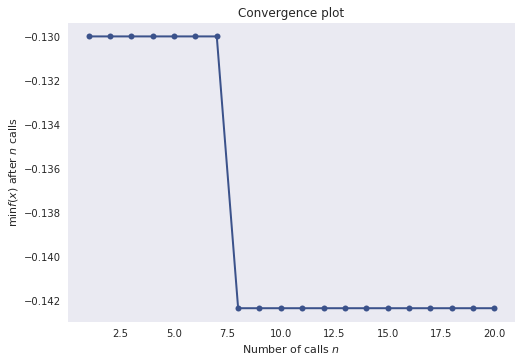

In [93]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [94]:
bo_pol.theta

array([ 4.071,  0.339,  0.133,  0.528,  1.   ])

In [95]:
np.save('data/low_stakes_trunc_1cents-6',bo_pol.theta)

In [96]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [97]:
np.mean(bo_utils)

0.14169658196955048

In [98]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [99]:
np.mean(mg_utils)

0.14241048998277861

In [100]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=-0.3804105282777559, pvalue=0.70372164993800035)

In [101]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=-0.59531649292444955, pvalue=0.55190181269268335)

In [102]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [103]:
np.mean(no_utils)

0.12999999999999998

In [104]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [105]:
np.mean(fo_utils)

-0.096061964254237783

In [106]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'low','cost':cost,'policy':p})

In [107]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.01,bo,low,0.098143
1,0.01,bo,low,0.099230
2,0.01,bo,low,0.105363
3,0.01,bo,low,0.133515
4,0.01,bo,low,0.197038
5,0.01,bo,low,0.203924
6,0.01,bo,low,0.142094
7,0.01,bo,low,0.128683
8,0.01,bo,low,0.168572
9,0.01,bo,low,0.080000


In [108]:
df[df['policy'] == 'metagreedy'].util.mean()

0.14241048998277894

In [109]:
df.to_hdf('data/low_stakes_trunc_1cents_results-6','results')

In [110]:
df2 = pd.read_hdf('data/low_stakes_trunc_1cents_results-6','results')

In [111]:
df2[df2['policy']=='bo'].util.mean()

0.141696581969551

In [112]:
theta= np.load('data/low_stakes_trunc_1cents-6.npy')
theta

array([ 4.071,  0.339,  0.133,  0.528,  1.   ])

## Validation

In [69]:
filenames = ['low_stakes_1cents-previous.npy', 'low_stakes_1cents.npy', 'low_stakes_trunc_1cents.npy', 'low_stakes_trunc_1cents-2.npy', 'low_stakes_trunc_1cents-3.npy', 'low_stakes_trunc_1cents-4.npy', 'low_stakes_trunc_1cents-5.npy']
low_stakes = TruncatedNormal((0.25+0.01)/2, 0.3*(0.25-0.01),0.01,0.25)
reward = low_stakes
test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train*4)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train*4)]

In [70]:
val_util = []
d_list = []
for polfil in filenames:
    bo_pol_theta = np.load('data/'+polfil)
    print(bo_pol_theta)
    bo_pol = LiederPolicy(list(bo_pol_theta))
    
    polutil_hd = get_util(bo_pol, test_envs_hd, parallel=Parallel(n_jobs=100),return_mean=False)
    print(np.mean(polutil_hd))
    for result in polutil_hd:
        d_list.append({'util':result,'disp':'hd','policy':polfil})
        
    polutil_ld = get_util(bo_pol, test_envs_ld, parallel=Parallel(n_jobs=100),return_mean=False)
    print(np.mean(polutil_ld))
    for result in polutil_ld:
        d_list.append({'util':result,'disp':'ld','policy':polfil})
        
    val_util.append(np.mean(polutil_hd))
    val_util.append(np.mean(polutil_ld))
df = pd.DataFrame(d_list)
df.to_hdf('data/low_stakes_val_1cents_results','results')

[ 1.  1.  0.  0.  1.]


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.155880241941
0.129594881144
[ 1.124  0.623  0.318  0.059  1.   ]


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.156111542019
0.125401986779
[ 1.328  0.828  0.167  0.005  1.   ]
0.156784734111
0.13
[ 4.071  0.339  0.133  0.528  1.   ]


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.155046458244
0.13
[ 4.071  0.339  0.133  0.528  1.   ]


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.155025520291
0.13
[ 1.  1.  0.  0.  1.]


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.155880241941
0.129594881144
[ 1.  1.  0.  0.  1.]


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.155880241941
0.129594881144


In [72]:
ordered = np.array(filenames)[np.argsort(np.mean(np.array(val_util).reshape(7,2),1))][::-1]

In [73]:
list(zip(ordered,np.sort(np.mean(np.array(val_util).reshape(7,2),1))[::-1]))

[('low_stakes_trunc_1cents.npy', 0.14339236705541725),
 ('low_stakes_trunc_1cents-5.npy', 0.14273756154257727),
 ('low_stakes_trunc_1cents-4.npy', 0.14273756154257727),
 ('low_stakes_1cents-previous.npy', 0.14273756154257727),
 ('low_stakes_trunc_1cents-2.npy', 0.14252322912178234),
 ('low_stakes_trunc_1cents-3.npy', 0.14251276014574243),
 ('low_stakes_1cents.npy', 0.1407567643988934)]

In [81]:
std_errs = [df[df['policy'] == polfil].util.std()*1.96/np.sqrt(2000) for polfil in filenames]

In [82]:
std_errs

[0.0013710719779671753,
 0.0014960608335911835,
 0.0012415434671854111,
 0.0011881177476536732,
 0.0011991098599670768,
 0.0013710719779671753,
 0.0013710719779671753]

In [85]:
mg_utils = list(df[df['policy'] == 'low_stakes_1cents-previous.npy'].util)
bo_utils = list(df[df['policy'] == 'low_stakes_trunc_1cents.npy'].util)

In [88]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)


Ttest_indResult(statistic=0.69386473571108442, pvalue=0.4878073523947164)

# Result fixing

In [14]:
df = pd.read_hdf('data/comb_val_1cents_results-2','results')
df.groupby('policy').util.mean()

policy
comb_1cents.npy                   3.645836
high_stakes_1cents-prev.npy       3.648174
high_stakes_1cents.npy            3.640578
high_stakes_trunc_1cents-2.npy    3.643652
high_stakes_trunc_1cents-3.npy    3.640808
high_stakes_trunc_1cents-4.npy    3.647734
high_stakes_trunc_1cents-5.npy    3.640774
high_stakes_trunc_1cents.npy      3.643476
hs_ld_1cents-2.npy                3.643588
low_stakes_1cents-previous.npy    3.649938
low_stakes_1cents.npy             3.648834
low_stakes_trunc_1cents-2.npy     3.646879
low_stakes_trunc_1cents-3.npy     3.649111
low_stakes_trunc_1cents.npy       3.651658
ls_hd_1cents-2.npy                3.647104
ls_ld_1cents-2.npy                3.631423
Name: util, dtype: float64

In [15]:
df[:10]

,disp,env_id,policy,stake,util
0,high,0,high_stakes_1cents.npy,high,5.999691
1,high,1,high_stakes_1cents.npy,high,9.630031
2,high,2,high_stakes_1cents.npy,high,7.737362
3,high,3,high_stakes_1cents.npy,high,8.431396
4,high,4,high_stakes_1cents.npy,high,6.989854
5,high,5,high_stakes_1cents.npy,high,8.513090
6,high,6,high_stakes_1cents.npy,high,8.076591
7,high,7,high_stakes_1cents.npy,high,7.065786
8,high,8,high_stakes_1cents.npy,high,8.801727
9,high,9,high_stakes_1cents.npy,high,6.278555


In [19]:
df[df['stake']=='high'][df['disp']=='low'].groupby('policy').util.mean()

/Users/sayangul/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


policy
comb_1cents.npy                   6.459792
high_stakes_1cents-prev.npy       6.458588
high_stakes_1cents.npy            6.452250
high_stakes_trunc_1cents-2.npy    6.471901
high_stakes_trunc_1cents-3.npy    6.460570
high_stakes_trunc_1cents-4.npy    6.466308
high_stakes_trunc_1cents-5.npy    6.458887
high_stakes_trunc_1cents.npy      6.470717
hs_ld_1cents-2.npy                6.471879
low_stakes_1cents-previous.npy    6.470943
low_stakes_1cents.npy             6.469036
low_stakes_trunc_1cents-2.npy     6.459526
low_stakes_trunc_1cents-3.npy     6.467650
low_stakes_trunc_1cents.npy       6.473890
ls_hd_1cents-2.npy                6.464633
ls_ld_1cents-2.npy                6.426627
Name: util, dtype: float64

In [17]:
df[df['stake']=='high'][df['disp']=='high'].groupby('policy').util.mean()

/Users/sayangul/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


policy
comb_1cents.npy                   7.842801
high_stakes_1cents-prev.npy       7.844545
high_stakes_1cents.npy            7.843455
high_stakes_trunc_1cents-2.npy    7.842706
high_stakes_trunc_1cents-3.npy    7.842660
high_stakes_trunc_1cents-4.npy    7.842756
high_stakes_trunc_1cents-5.npy    7.844211
high_stakes_trunc_1cents.npy      7.843188
hs_ld_1cents-2.npy                7.842474
low_stakes_1cents-previous.npy    7.843247
low_stakes_1cents.npy             7.843721
low_stakes_trunc_1cents-2.npy     7.843095
low_stakes_trunc_1cents-3.npy     7.842580
low_stakes_trunc_1cents.npy       7.844729
ls_hd_1cents-2.npy                7.842675
ls_ld_1cents-2.npy                7.839063
Name: util, dtype: float64

In [18]:
df[df['stake']=='low'][df['disp']=='high'].groupby('policy').util.mean()

/Users/sayangul/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


policy
comb_1cents.npy                   0.155913
high_stakes_1cents-prev.npy       0.159859
high_stakes_1cents.npy            0.152682
high_stakes_trunc_1cents-2.npy    0.130000
high_stakes_trunc_1cents-3.npy    0.130000
high_stakes_trunc_1cents-4.npy    0.155922
high_stakes_trunc_1cents-5.npy    0.130000
high_stakes_trunc_1cents.npy      0.130000
hs_ld_1cents-2.npy                0.130000
low_stakes_1cents-previous.npy    0.156031
low_stakes_1cents.npy             0.157207
low_stakes_trunc_1cents-2.npy     0.154894
low_stakes_trunc_1cents-3.npy     0.156214
low_stakes_trunc_1cents.npy       0.158012
ls_hd_1cents-2.npy                0.155913
ls_ld_1cents-2.npy                0.130000
Name: util, dtype: float64

In [20]:
df[df['stake']=='low'][df['disp']=='low'].groupby('policy').util.mean()

/Users/sayangul/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


policy
comb_1cents.npy                   0.124837
high_stakes_1cents-prev.npy       0.129703
high_stakes_1cents.npy            0.113925
high_stakes_trunc_1cents-2.npy    0.130000
high_stakes_trunc_1cents-3.npy    0.130000
high_stakes_trunc_1cents-4.npy    0.125950
high_stakes_trunc_1cents-5.npy    0.130000
high_stakes_trunc_1cents.npy      0.130000
hs_ld_1cents-2.npy                0.130000
low_stakes_1cents-previous.npy    0.129531
low_stakes_1cents.npy             0.125373
low_stakes_trunc_1cents-2.npy     0.130000
low_stakes_trunc_1cents-3.npy     0.130000
low_stakes_trunc_1cents.npy       0.130000
ls_hd_1cents-2.npy                0.125195
ls_ld_1cents-2.npy                0.130000
Name: util, dtype: float64

In [43]:
def read_ombo_policy(reward_mu, reward_sigma, outcome_probs, cost=0.01):
    """Returns optimized policy for the given environment parameters"""
    stakes = 'hs' if reward_mu == 5.0 else 'ls'
    disp = 'hd' if np.max(outcome_probs) >= 0.85 else 'ld'
    cents = str(int(100*cost))
    polfil = 'data/om_bmps_pols/best/'+stakes+'_'+disp+'_'+cents+'cents.npy'
#     print(polfil)
    bo_pol_theta = np.load(polfil)
#     print(bo_pol_theta)
    return LiederPolicy(list(bo_pol_theta))

In [48]:
read_ombo_policy(0.3,20,[0.86,0.19])

data/om_bmps_pols/best/ls_hd_1cents.npy
[ 1.328  0.828  0.167  0.005  1.   ]
